## Data 558 Final Project - Code part 2: 
**Based on milestone in homeworks 7 and 8**

Alyssa Goodrich  
June 4, 2017

**Section 1: Load packages and clean data, and write some basic utility functions (e.g., create a file for kaggle submissions)**

In [1]:
#Load necessary packages
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import math
from scipy.linalg import eigh as largest_eigh
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from IPython.core.debugger import Tracer
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.svm import SVC
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


In [2]:
data = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/features.csv', sep=',', header=None)
labels = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/labels.csv', sep=',', header=None)
testFeatures = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/testFeatures.csv', sep=',', header=None)
testLabels = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/testLabels.csv', sep=',', header=None, dtype = int)
testLabels = np.array(testLabels)[:,0]
dataLabels = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/DataLabels.csv', sep=',', header=None)
dataLabels = np.array(dataLabels)
dataLabels[:,0]
y = labels
y = np.array(y)
x = data
Cats, y = np.unique(y, return_inverse = True)
# ySub = (y <10)
# x= x[ySub]
# y = y[ySub]
xMean = np.mean(x, axis = 0)
xStd = np.std(x, axis = 0)
testFeatures = (testFeatures - xMean)/xStd
x = (x - np.mean(x, axis =0))/(np.std(x,axis = 0))
x = np.array(x)

#Thanks to scikit learn documentation for demonstrating this way to extract a training set with same proportions of samples in test and train set as in original data 
from sklearn.model_selection import StratifiedShuffleSplit
def splitTestTrain(x, y, testPCT, numSplits):
    sss = StratifiedShuffleSplit(n_splits=numSplits, test_size=testPCT, random_state=0)
    for train_index, test_index in sss.split(x,y):
        xTrain, xTest = x[train_index], x[test_index]
        yTrain, yTest = y[train_index], y[test_index]
        return (xTrain, xTest,yTrain, yTest)

xTrain, xTest,yTrain, yTest = splitTestTrain(x,y,.2, 1)
beta_init = np.zeros(x.shape[1])
testingBetas = np.random.randint(-50,50, size = x.shape[1])/50


In [3]:
#I trained all my data using different numerical interpretation of bird name strings. This function maps my numerical interpretation back into the expected numerical interpretation.

def convertY(preds, Cats = Cats, labels = dataLabels):
    #preds is my predictions based on my categories
    #Cats is the link back to the name of the bird from my category
    #Labels is the correct bird / number mapping as defined by the contest organizer
    namePreds = Cats[preds]
    numPreds = ()
    namPredsCheck = ()
    
    for i in range(len(preds)):
        newCatPred = labels[np.where(labels[:,1] == Cats[preds][i])[0],0]  
        newNamePred = labels[np.where(labels[:,1] == Cats[preds][i])[0],1]
        #print(i,newCatPred,newNamePred)
        numPreds = np.append(numPreds, newCatPred)
        namPredsCheck = np.append(namPredsCheck, newNamePred)
    return(numPreds)


In [6]:
#create a function to keep a table of all predictions I have made and the name of model that created each prediction
currentModelList = ()

def predictionLog(predictions, modelName, currentModelList, PredictionLog):
    #predictions are the predictions you want to add to the log
    #ModelName is the model that created the predictions you want to add 
    #CurrentModelList is a list of models with predictions currently in the log (If ModelName is not on currentModelList then the function will create a new column for the predictions. If the modelName is already on the list the function will overwrite the old predictions for that model with new predictions for the model.)
    if len(currentModelList) == 0:
        PredictionLog = predictions
        currentModelList = np.append(currentModelList, modelName)
        PredictionLog = PredictionLog
    elif modelName in currentModelList:
        index = np.where(currentModelList == modelName)[0]
        PredictionLog[index,:] = deepcopy(predictions) #[:, np.newaxis])
    else:
        index = len(currentModelList)
#         print('PredictionLog.shape:',PredictionLog.shape, PredictionLog.ndim)
#         print('predictions.shape:',predictions.shape)

        PredictionLog = np.vstack((PredictionLog, predictions))
        currentModelList = np.append(currentModelList, modelName)
    PredictionLog = np.array(PredictionLog)
    return(PredictionLog, currentModelList)
    
    

In [16]:
#create a function to turn my predictions into a submission file
def predstoFile(preds, filename):
    newpreds = convertY(preds, Cats, dataLabels) #Converts predictions using my labels to predictions with the standard labels
    LabsPreds = np.stack((testLabels,newpreds)).T # links predictions to corresponding image label
    LabsPreds = LabsPreds.astype(int) #converts to integer type for sorting
    LabsPreds = LabsPreds[np.argsort(LabsPreds[:, 0])]
    names = np.array(['Id', 'Prediction'])
    LabsPreds = np.vstack((names, LabsPreds))
    np.savetxt(filename, LabsPreds, delimiter = ",", fmt='%s')
    return


**This section is based on the milestones in homework 7**  
  
**Bullet 1:** In a one-vs-one fashion, for each pairs of classes, train a linear SVM classiﬁer using scikit-learn’s function LinearSVC, with the default value for the regularization parameter. Compute the multi-class misclassiﬁcation error obtained using these classiﬁers trained in a one-vs-one fashion. 

In [517]:
#Initialize function to extract two categories from data to use in training for one versus one 

def subset_data_1v1(x, y, c, c1):
    #x is the dataset with features
    #y is the dataset with labels
    #c is the category that was chosen (i.e., y[y ==c] = 1)
    #c1 is the category that we will compare c to (i.e., y[y ==c1] =-1)
    #outputs a new dataset with only two categories yBin is a binary version of y where category c = 1 and category c1 = -1
    if sum(y == c) == 0: 
            raise ('Category selected does not exist in this data') 
    else:
        ysubc = ((y==c)+(y==c1))
        y, x = y[ysubc], x[ysubc]
        yBin = deepcopy(y)
        yBin[y==c1], yBin[y==c] = -1, 1
        
       
    return(x, y, yBin)

In [9]:
#Initialize a function to create predictions for each combination of classes in 1v1 
def oneVsoneCreatePreds(xTrain, yTrain, xTest, lam = 1):
    Cs = np.unique(yTrain)
    Models = np.ndarray([len(Cs), len(Cs), xTrain.shape[1]])    
    Preds = np.ndarray([len(Cs), len(Cs), xTest.shape[0]])
    for i in range(len(Cs)):
        c = Cs[i]
        for j in range(len(Cs)):
            c1 = Cs[j]
            if c == c1:
                Preds[np.where(Cs == c1)[0],np.where(Cs == c)[0],:] = np.zeros(xTest.shape[0])

            else:
                xTemp, yTemp, yBin = subset_data_1v1(x = xTrain, y =yTrain, c = c, c1= c1)
                model = LinearSVC(fit_intercept = False, C = lam)
                model.fit(xTemp,yBin)
                Preds[np.where(Cs == c1)[0],np.where(Cs == c)[0],:] = model.predict(xTest)
    PredSum = np.sum(Preds, axis = 0) #Sums all the predictions
    MaxPredIndex = np.argmax(PredSum, axis = 0) # Finds the index that is most often predicted
    CatPred = Cs[MaxPredIndex]
    return(CatPred)        
           

In [10]:
# Initialize a function to calculate the misclassificatin error
def CalcError(xTest, yTest, xTrain, yTrain, PredictionModel, lam = 1):
    Preds = PredictionModel(xTrain = xTrain, yTrain=yTrain, xTest= xTest, lam = 1)
    error = 1- np.mean(np.equal(Preds,yTest))
    return(error)
    

In [10]:
#Use the above functions to create predictions for 1 vs 1
Models1V1 = oneVsoneCreateModels(x = xTrain, y = yTrain, lam = 1)
Preds1v1 = oneVsoneMakePredictions(x = xTest, y = yTest, Models = Models1V1)

error1v1 = 1- np.mean(np.equal(Preds1v1,yTest))
print("The error using a one vs one approach is:", error1v1)


The error using a one vs one approach is: 0.335648148148


**Bullet 2:** In a one-vs-rest fashion, for each class, train a linear SVM classifier using scikit-learn’s function LinearSVC, with the default value for λc. Compute the multi-class misclassification error obtained using these classifiers trained in a one-vs-rest fashion.

In [11]:
#Initialize a function to create models to classify each element C vs all elements not equal to C
 
def oneVsRestCreateModels(x, y, lam = 1):
    model = LinearSVC(fit_intercept = False, C = lam, class_weight = 'balanced', multi_class = 'ovr')
    model.fit(x,y)
    coef = model.coef_
    return(coef)        

In [12]:
def oneVsRestMakePredictions(yTest,xTest, Models):
    # X is input data
    # y is response data
    # Models is a matrix of models used to create predictions for the response
    Cs = np.unique(yTest)
    Predictions = np.zeros([Models.shape[0], xTest.shape[0]])    
    
    for i in range(Predictions.shape[0]):
        if i % 10 == 0:
            print(i)
        c = Cs[i]
        betaTemp = Models[i,:]
        pred = 1/(1+np.exp(-xTest.dot(betaTemp)))
        Predictions[i,:] = deepcopy(pred) 
    MaxPredIndex = np.argmax(Predictions, axis = 0) # Finds the index that is most often predicted
    CatPred = Cs[MaxPredIndex]# Finds the category assocated with the index
    return(CatPred)  


In [14]:
Models1VR = oneVsRestCreateModels(x = xTrain, y = yTrain, lam = 1)
OneVRPreds = oneVsRestMakePredictions(xTest = xTest, yTest = yTest, Models = Models1VR)
error1vR = 1- np.mean(np.equal(OneVRPreds,yTest))
print("The error using a one vs rest approach is:", error1vR)

# error1VR = CalcError(xTest = xTest, yTest = yTest, xTrain = xTrain, yTrain = yTrain, CreationModel =oneVsRestCreateModels, PredictionModel = oneVsRestMakePredictions, lam = 1 )

# print("The error using a one versus rest approach is:", error1vR)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
The error using a one vs rest approach is: 0.712962962963


**Bullet 3:** Using the option multi class=’crammer singer’ in scikitlearn’s function LinearSVC, train a multi-class linear SVM classifier using the default value for the regularization parameter. Compute the multi-class misclassification error obtained using this multiclass linear SVM classifier.

In [13]:
 def oneVsRestCreateModelCS(x, y, lam = 1):
    model = LinearSVC(fit_intercept = False, C = lam, class_weight = 'balanced', multi_class = 'crammer_singer')
    model.fit(x,y)
    coef = model.coef_
    return(coef)        

In [17]:
Models1VRCS = oneVsRestCreateModelCS(x = xTrain, y = yTrain, lam = 1)
OneVRPredsCS = oneVsRestMakePredictions(xTest = xTest, yTest = yTest, Models = Models1VRCS)
errorCS = 1- np.mean(np.equal(OneVRPredsCS,yTest))
print("The error using Crammer-Singer is:", errorCS)

# errorCS = CalcError(xTest = xTest, yTest = yTest, xTrain = xTrain, yTrain = yTrain, CreationModel =oneVsRestCreateModelCS, PredictionModel = oneVsRestMakePredictions, lam = 1 )
# print("The error using Crammer-Singer is:", errorCS)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
The error using Crammer-Singer is: 0.324074074074


**Linear SVMs for multi-class classification:** Redo all questions above now tuning the regularization parameters using cross-validation.

**One vs one**

In [11]:
pool = ThreadPool(7)
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000)
#Corinne, thanks for tip on using print statements to test whether we are parallel processing despite global variables. We are. 
def findError1V1Test(lam):
    print("a")
    Preds1v1 = oneVsoneCreatePreds(xTrain, yTrain, xTest, lam = lam)
    print("b")
    error1v1 = 1- np.mean(np.equal(Preds1v1,yTest))
    return(error1v1, Preds1v1)
resultsOvO = pool.map(findError1V1Test, lambdas)
pool.close
pool.join
       
errors = np.asarray([x[0] for x in resultsOvO]).T
print("The errors corresponding to lambdas are:", errors)
a = errors.shape[0]
LamError = np.append(lambdas, errors)
LamError = np.reshape(LamError, (2, a))
np.savetxt("OneVOneError.csv", LamError, delimiter = ",")


preds = np.asarray([x[1] for x in resultsOvO]).T
a,b =(preds.shape)
LamPred = np.append(lambdas, preds)
LamPred = np.reshape(LamPred, (a+1, b))
np.savetxt("OneVOnePreds.csv", LamPred, delimiter = ",")


aa
a
a

a
a
a
b
a
b
a
b
b
b
b
b
b
b
The errors corresponding to lambdas are: [ 0.49768519  0.38888889  0.33912037  0.33680556  0.33564815  0.33564815
  0.33564815  0.33564815  0.33564815]


In [121]:
#Calculate predictions with the lambda we determeined to be the best lambda
Preds1v1 = oneVsoneCreatePreds(x, y, testFeatures, lam = .1)

#Add our 1 v 1 with optimal lambda to the prediction log so I can later use it to vote on the best prediction
PredictionLog, currentModelList = predictionLog(Preds1v1, 'OneVOneLam01', currentModelList = currentModelList, PredictionLog = PredictionLog)


array([114,  41,  49, ...,  94,  93,  69])

**One vs Rest**

In [345]:
#Createp one vs rest predictions 
def oneVsRestCreatePreds(xTrain, yTrain, xTest, lam = 1):
    model = LinearSVC(fit_intercept = False, C = lam, class_weight = 'balanced', multi_class = 'ovr')
    model.fit(xTrain,yTrain)
    Preds = model.predict(xTest)
    return(Preds)        

In [7]:
#Cross validate using an array of lambdas to find the best lambda
pool = ThreadPool(7)
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000)

def findError1VR(lam):
#     print("a")
    OneVRPreds = oneVsRestCreatePreds(xTrain, yTrain, xTest, lam = lam)
    error1vR = 1- np.mean(np.equal(OneVRPreds,yTest))
    return(error1vR, OneVRPreds)

resultsOvR = pool.map(findError1VR, lambdas)
pool.close
pool.join
           
errors = np.asarray([x[0] for x in resultsOvR]).T
print("The errors corresponding to lambdas are:", errors)
a = errors.shape[0]
LamError = np.append(lambdas, errors)
LamError = np.reshape(LamError, (2, a))
np.savetxt("OneVRError.csv", LamError, delimiter = ",")


preds = np.asarray([x[1] for x in resultsOvR]).T
a,b =(preds.shape)
LamPred = np.append(lambdas, preds)
LamPred = np.reshape(LamPred, (a+1, b))
np.savetxt("OneVRPreds.csv", LamPred, delimiter = ",")


The errors corresponding to lambdas are: [ 0.45138889  0.37268519  0.35763889  0.40972222  0.48726852  0.69791667 0.74768519  0.74768519  0.74189815]


**Crammer Singer**

In [352]:
 def oneVsRestCreatePredsCS(xTrain, yTrain, xTest, lam = 1):
    model = LinearSVC(fit_intercept = False, C = lam, class_weight = 'balanced', multi_class = 'crammer_singer')
    model.fit(xTrain,yTrain)
    preds = model.predict(xTest)
    
    return(preds)  

In [16]:
pool = ThreadPool(7)
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000)

def findError1VRCS(lam):
    OneVRPredsCS = oneVsRestCreatePredsCS(xTrain, yTrain, xTest, lam = lam)
    errorCS = 1- np.mean(np.equal(OneVRPredsCS,yTest))
    return(errorCS, OneVRPredsCS)
resultsOvRCS = pool.map(findError1VRCS, lambdas)
pool.close
pool.join
# print(resultsOvRCS)
       
errors = np.asarray([x[0] for x in resultsOvRCS]).T
print("The errors corresponding to lambdas are:", errors)
a = errors.shape[0]
LamError = np.append(lambdas, errors)
LamError = np.reshape(LamError, (2, a))
np.savetxt("OneVRCSError.csv", LamError, delimiter = ",")


preds = np.asarray([x[1] for x in resultsOvRCS]).T
a,b =(preds.shape)
LamPred = np.append(lambdas, preds)
LamPred = np.reshape(LamPred, (a+1, b))
np.savetxt("OneVRCSPreds.csv", LamPred, delimiter = ",")

The errors corresponding to lambdas are: [ 0.36689815  0.36458333  0.31365741  0.32407407  0.32407407  0.32407407
  0.32407407  0.32407407  0.32407407]


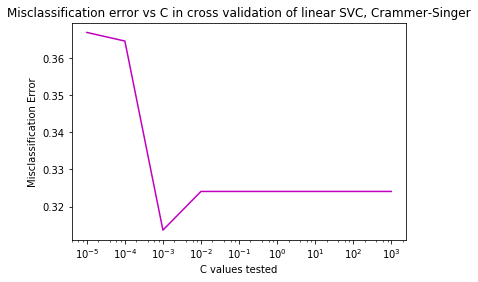

In [520]:
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000)
errors = np.array((0.36689815,  0.36458333,  0.31365741,  0.32407407,  0.32407407,  0.32407407, 0.32407407,  0.32407407,  0.32407407))  
fig, ax = plt.subplots()
ax.plot(lambdas,errors, 'm-')
plt.xlabel('C values tested')
plt.ylabel('Misclassification Error')
plt.title('Misclassification error vs C in cross validation of linear SVC, Crammer-Singer')

ax.plot()
plt.xscale('log')

In [351]:
model = LinearSVC(fit_intercept = False, C = .001, class_weight = 'balanced', multi_class = 'crammer_singer')
model.fit(x,y)
preds = model.predict(testFeatures)
predstoFile(preds, 'CrammerSingerPreds.csv')

(4320, 2048)


In [475]:
#train model using best lambda and complete training data set, then predict using test features.

OneVRPredsCS = oneVsRestCreatePredsCS(x, y, testFeatures, lam = .001)
# Add predictions to prediction log
PredictionLog, currentModelList = predictionLog(OneVRPredsCS, 'CramSingLam001', currentModelList = currentModelList, PredictionLog = PredictionLog)


PredictionLog.shape: (4320,) 1
predictions.shape: (4320,)


In [78]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]}
model = LinearSVC(fit_intercept = False, C = .001, class_weight = 'balanced', multi_class = 'crammer_singer')
GS_Model = GridSearchCV(model, parameters, n_jobs = -1)
GS_Model.fit(x, y)
results = GS_Model.cv_results_


In [38]:
preds = GS_Model.predict(testFeatures)
# predstoFile(preds, filename):
# newpreds = convertY(preds, Cats, dataLabels) #Converts predictions using my labels to predictions with the standard labels
convertY(preds = preds, Cats = Cats, labels = dataLabels)
# preds

array([], dtype=object)

** HW 8 Bullet 1**
In this section I will train and cross validate a number of models

In [490]:
#Build a function to extract scores from various kernel options
def myKernel(kernel, c, degree, xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest):
    model= SVC(C= c, kernel=kernel, degree=degree, gamma='auto',  class_weight='balanced', decision_function_shape='ovr', random_state=0)
    model.fit(xTrain, yTrain)
    predictions = model.predict(xTest)
    score = model.score(xTest,yTest)
    return(predictions, score)

In [491]:
# BestPoly = myKernel(kernel = 'poly', c = 1, degree = 3, xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest)

In [492]:
#Build a function to test various options to find the best polynomial kernel
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000,10000,100000,1000000)
degrees = (2,3,4,5,6,7,8,9)
# lambdas = (.00001, .0001)
# degrees = (2,3,4)
def bestPoly(lambdas, degrees , xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest):
    nlams = len(lambdas)
    ndegs = len(degrees)
    allPreds = np.zeros((nlams, ndegs, yTest.shape[0]))
    scores = np.zeros((nlams, ndegs))
    bestPreds = np.zeros((ndegs, yTest.shape[0]))
    for i in range(len(lambdas)):
        c = lambdas[i]
        for j in range(len(degrees)):
            degree = degrees[j]
            allPreds[i, j, :], scores[i,j] = myKernel(kernel = 'poly', c = c, degree = degree)
    scores = pd.DataFrame(data=scores, index=lambdas, columns=degrees)
    return(allPreds, scores)

In [493]:
test = bestPoly(lambdas = lambdas, degrees = degrees)

In [59]:
#Shows the scores for degree (top axis) and lambda (size axis). Looks like polynomial degree two with lambda 10 can't be beat
test[1]

,2,3,4,5,6,7,8,9
0.00001,0.466667,0.216667,0.103333,0.046667,0.026667,0.023333,0.023333,0.020000
0.00010,0.466667,0.216667,0.103333,0.046667,0.026667,0.023333,0.023333,0.020000
0.00100,0.466667,0.216667,0.103333,0.046667,0.026667,0.023333,0.023333,0.020000
0.01000,0.466667,0.216667,0.103333,0.046667,0.026667,0.023333,0.026667,0.030000
0.10000,0.490000,0.260000,0.136667,0.080000,0.070000,0.066667,0.063333,0.060000
1.00000,0.713333,0.526667,0.290000,0.176667,0.116667,0.106667,0.086667,0.073333
10.00000,0.736667,0.653333,0.450000,0.256667,0.180000,0.120000,0.103333,0.090000
100.00000,0.736667,0.660000,0.466667,0.286667,0.180000,0.130000,0.110000,0.093333
1000.00000,0.736667,0.660000,0.466667,0.286667,0.200000,0.136667,0.106667,0.090000


In [522]:
#Fit best polynomial model and save predictions to prediction log
model= SVC(C= 10, kernel='poly', degree=2, gamma='auto',  class_weight='balanced', decision_function_shape='ovr', random_state=0)
model.fit(x, y)
polyOrder2Lam10Preds = model.predict(testFeatures)
PredictionLog, currentModelList = predictionLog(polyOrder2Lam10Preds, 'polyOrder2Lam10', currentModelList = currentModelList, PredictionLog = PredictionLog)

# predstoFile(preds, 'polyOrder2Lam10.csv')
# len(np.unique(preds))

In [89]:
#Find best parameters for RBF kernel
pool = ThreadPool(7)
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000)

# lambdas = (.00001, .0001)
def bestLamRBF(lam):
    allPreds, scores = myKernel(kernel = 'rbf', degree = 0, c = lam, xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest)
    return(allPreds, scores)

resultsRBF = pool.map(bestLamRBF, lambdas)
pool.close
pool.join
# print(resultsOvRCS)
       
scores = np.asarray([x[1] for x in resultsRBF]).T
print("The scores corresponding to lambdas are:", scores)
a = scores.shape[0]
LamScore = np.append(lambdas, scores)
LamScore = np.reshape(LamScore, (2, a))
np.savetxt("ScoresRBF.csv", LamScore, delimiter = ",")


preds = np.asarray([x[0] for x in resultsRBF]).T
a,b =(preds.shape)
LamPred = np.append(lambdas, preds)
LamPred = np.reshape(LamPred, (a+1, b))
np.savetxt("RBFPreds.csv", LamPred, delimiter = ",")

The scores corresponding to lambdas are: [ 0.56134259  0.56134259  0.56134259  0.56134259  0.56134259  0.62731481
  0.65046296  0.65046296  0.65046296]


In [101]:
parameters = {'C':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000], 'gamma':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]}
model = SVC( kernel='rbf', degree=0,  class_weight='balanced', decision_function_shape='ovr', random_state=0)

RBF_Model = GridSearchCV(model, parameters, n_jobs = -1)
RBF_Model.fit(x, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=0, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [477]:
#Fit model using best parameters and save to prediction log
RBFmodel= SVC(kernel='rbf', C = 10, gamma = .0001, degree=0,  class_weight='balanced', decision_function_shape='ovr', random_state=0)
RBFmodel.fit(x, y)
RBFLam10Gam0001Preds = RBFmodel.predict(testFeatures)
PredictionLog, currentModelList = predictionLog(RBFLam10Gam0001Preds, 'RBFLam10Gam0001', currentModelList = currentModelList, PredictionLog = PredictionLog)


PredictionLog.shape: (3, 4320) 2
predictions.shape: (4320,)


In [103]:
RBFBestScore = RBF_Model.best_score_
RBFBestParams = RBF_Model.best_params_
RBFBestIndex = RBF_Model.best_index_
print(RBFBestScore)
print(RBFBestParams)
print(RBFBestIndex)

0.679166666667
{'C': 10, 'gamma': 0.0001}
55


In [102]:
parameters = {'C':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000], 'gamma':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]}
model = SVC( kernel='rbf', degree=0,  class_weight='balanced', decision_function_shape='ovo', random_state=0)

RBFOVO_Model = GridSearchCV(model, parameters, n_jobs = -1)
RBFOVO_Model.fit(x, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=0, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [100]:
RBFOvOBestScore = RBFOVO_Model.best_score_
RBFOvOBestParams = RBFOVO_Model.best_params_
RBFOvOBestIndex = RBFOVO_Model.best_index_
print(RBFOvOBestScore)
print(RBFOvOBestParams)
print(RBFOvOBestIndex)


0.679166666667
{'C': 10, 'gamma': 0.0001}
55


In [79]:
#find best parameters for sigmoid fuction
parameters = {'C':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000], 'gamma':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]}
model = SVC( kernel='sigmoid', degree=0,  class_weight='balanced', decision_function_shape='ovr', random_state=0)

Sigmoid_Model = GridSearchCV(model, parameters, n_jobs = -1)
Sigmoid_Model.fit(x, y)


In [96]:
# # Sigresults = Sigmoid_Model.cv_result
SigmoidBestScore = Sigmoid_Model.best_score_
SigmoidBestParams = Sigmoid_Model.best_params_
SigmoidBestIndex = Sigmoid_Model.best_index_
print(SigmoidBestScore)
print(SigmoidBestParams)
print(SigmoidBestIndex)
Sigmoid_Model.best_score_

0.676157407407
{'C': 1000, 'gamma': 1e-05}
72


0.67615740740740737

In [523]:
parameters = {'C':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000], 'gamma':[.00001, .0001, .001, .01, .1, 1, 10, 100, 1000]}
model = SVC( kernel='sigmoid', degree=0,  class_weight='balanced', decision_function_shape='ovo', random_state=0)

SigmoidOVO_Model = GridSearchCV(model, parameters, n_jobs = -1)
SigmoidOVO_Model.fit(x, y)
SigOVOresults = Sigmoid_Model.cv_results_


In [98]:
SigmoidovoBestScore = SigmoidOVO_Model.best_score_
SigmoidovoBestParams = SigmoidOVO_Model.best_params_
SigmoidovoBestIndex = SigmoidOVO_Model.best_index_
print(SigmoidovoBestScore)
print(SigmoidovoBestParams)
print(SigmoidovoBestIndex)


0.676157407407
{'C': 1000, 'gamma': 1e-05}
72


In [478]:
#Fit model with best parameters and save to prediction log
Sigmodel= SVC(kernel='sigmoid', C = 1000, gamma = .00001, degree=0,  class_weight='balanced', decision_function_shape='ovr', random_state=0)
Sigmodel.fit(x, y)
SigLam1000Gam00001Preds = Sigmodel.predict(testFeatures)
PredictionLog, currentModelList = predictionLog(SigLam1000Gam00001Preds, 'SigLam1000Gam00001', currentModelList = currentModelList, PredictionLog = PredictionLog)


PredictionLog.shape: (4, 4320) 2
predictions.shape: (4320,)


In [90]:
pool = ThreadPool(7)
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000)

# lambdas = (.00001, .0001)
def bestLamSigmoid(lam):
    allPreds, scores = myKernel(kernel = 'sigmoid', degree = 0, c = lam, xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest)
    return(allPreds, scores)

resultsSigmoid = pool.map(bestLamSigmoid, lambdas)
pool.close
pool.join
# print(resultsOvRCS)
       
scores = np.asarray([x[1] for x in resultsSigmoid]).T
print("The scores corresponding to lambdas are:", scores)
a = scores.shape[0]
LamScore = np.append(lambdas, scores)
LamScore = np.reshape(LamScore, (2, a))
np.savetxt("ScoresSigmoid.csv", LamScore, delimiter = ",")


preds = np.asarray([x[0] for x in resultsSigmoid]).T
a,b =(preds.shape)
LamPred = np.append(lambdas, preds)
LamPred = np.reshape(LamPred, (a+1, b))
np.savetxt("SigmoidPreds.csv", LamPred, delimiter = ",")

The scores corresponding to lambdas are: [ 0.50578704  0.50578704  0.50578704  0.50578704  0.50578704  0.61574074
  0.63888889  0.61111111  0.61111111]


**HW 8 Bullet 2 **

In [524]:
#Review prediction log with best models. Let them all vote on the best one. Submit vote to kaggle. shucks - this does terribly in kaggle! 
print(PredictionLog)
print(currentModelList)
a = stats.mode(PredictionLog)
bestGuess = a[0]
predstoFile(bestGuess.T, 'bestGuess.csv')

[[114  41  49 ...,  94  93  69]
 [ 22  91  49 ...,  94  93  25]
 [114  91  49 ...,  94  93  69]
 [ 36  36  36 ...,  36  36  36]
 [ 22  41  49 ...,  94  93  78]]
['OneVOneLam01' 'CramSingLam001' 'polyOrder2Lam10' 'RBFLam10Gam0001'
 'SigLam1000Gam00001']


In [22]:
LinSVC = SVC(kernel = 'linear',degree=2, gamma='auto', C = .1, probability = True, decision_function_shape = 'ovo')

SVMPoly2 = SVC(kernel='poly', degree=2, gamma='auto', C = 10, probability = True)
RBF = SVC( kernel='rbf', C = 10, probability = True)
LogReg = LogisticRegression()

# VotingHard = VotingClassifier(estimators=[('LogReg', LogReg), ('SVMPoly2', SVMPoly2), ('RBF', RBF), ('LinSVC', LinSVC)],  weights = [.28, .24, .24, .24], n_jobs = -1, voting='hard')
# VotingHard.fit(x, y)
# PredsHard = (VotingHard.predict(testFeatures))
# predstoFile(PredsHard, 'VotingHardPreds.csv')
print("begin soft voting computation")
VotingSoft = VotingClassifier(estimators=[('LinSVC', LinSVC), ('LogReg', LogReg), ('SVMPoly2', SVMPoly2), ('RBF', RBF)],  n_jobs = -1, voting='soft')
VotingSoft.fit(x, y)
PredsSoft = (VotingSoft.predict(testFeatures))
predstoFile(PredsSoft, 'VotingSoftPreds.csv')


begin soft voting computation


In [17]:
predstoFile(PredsHard, 'VotingHardPreds.csv')

In [25]:
LinSVC = SVC(kernel = 'linear', probability = True)
SVMPoly2 = SVC(kernel='poly',probability = True)
RBF = SVC( kernel='rbf',probability = True)
LogReg = LogisticRegression()

VotingSoft = VotingClassifier(estimators=[('LogReg', LogReg), ('SVMPoly2', SVMPoly2), ('RBF', RBF), ('LinSVC', LinSVC), ('Sigmoid', Sigmoid)], n_jobs = -1, voting='soft')
VotingSoft.fit(x, y)
PredsSoft = (VotingSoft.predict(testFeatures))
predstoFile(PredsSoft, 'VotingSoftPredsfive.csv')
